In [1]:
# Sample API
import flowx
import simulation
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 100, 50
xmin, xmax = -3.0, 7.0
ymin, ymax = -2.5, 2.5

Re   = 100.0
dt   = 1e-1
tmax = 10.

ibm_x = 0.0
ibm_y = 0.0
ibm_r = 0.5

# Define cell-centered variable names
center_vars = ['pres', 'divv']
face_vars   = ['velc', 'hvar']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'outflow', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [1.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'neumann', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=10.0, dt=0.01, Re=100.0)

In [3]:
simulation.set_initial_velocity(gridc, gridx, gridy, 'velc', 'pres')

------------ Time = 0.0 ---------------
Number of poisson iterations    : 1
Final poisson residual : 0.0
Max, Min, U   : 1.0, -1.0
Max, Min, V   : 0.0, 0.0
Max, Min, P   : 0.0, 0.0
Max, Min, DIV : 0.0, 0.0




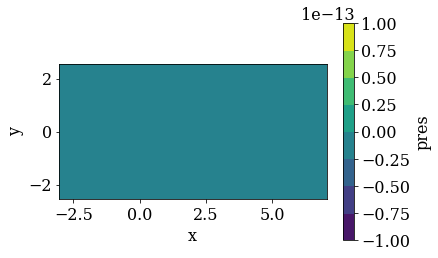

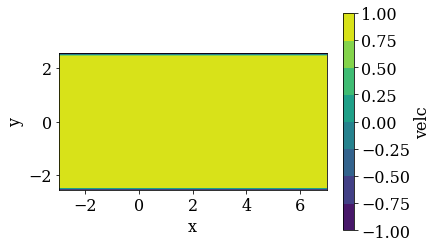

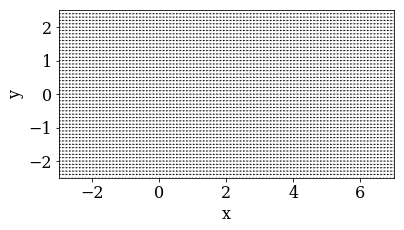

------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 1.5049148183563613e-06
Max, Min, U   : 1.0304485305248494, -1.0
Max, Min, V   : 0.06038762492466111, -0.06038762492466111
Max, Min, P   : 0.6265895527582843, -0.3439962234682889
Max, Min, DIV : 3.7436205548328425e-06, -1.0352453297974608e-05


------------ Time = 0.20000000000000004 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 9.494050873446768e-07
Max, Min, U   : 1.0438459714781276, -1.0
Max, Min, V   : 0.085808671904656, -0.0858086719046561
Max, Min, P   : 0.6069066175759834, -0.26126737201742056
Max, Min, DIV : 9.463261283482183e-07, -6.490802797548545e-06


------------ Time = 0.3000000000000001 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 8.950039638268348e-07
Max, Min, U   : 1.0614111168265823, -1.0
Max, Min, V   : 0.10328247408288499, -0.10328247408288506
Max, Min, P   : 0.5811914968825489, -

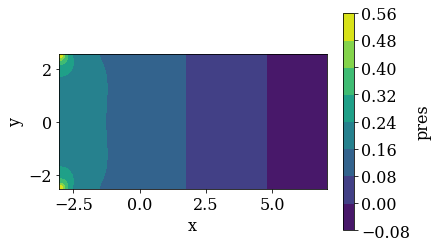

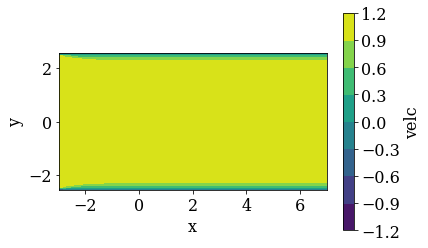

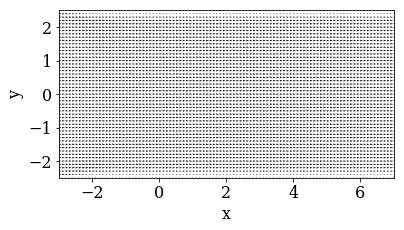

------------ Time = 1.1000000000000008 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 1.3311420337852413e-07
Max, Min, U   : 1.1220038404519797, -1.0
Max, Min, V   : 0.11668293674929009, -0.11668293674929014
Max, Min, P   : 0.5177928285207195, -0.05406879654135193
Max, Min, DIV : 6.768524414280108e-07, -8.130885250498196e-07


------------ Time = 1.2000000000000008 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 1.1277518948461743e-07
Max, Min, U   : 1.1248091327970104, -1.0
Max, Min, V   : 0.1178886569125065, -0.11788865691250644
Max, Min, P   : 0.5147569148234558, -0.04831842389209424
Max, Min, DIV : 6.334260079787768e-07, -6.312945331405674e-07


------------ Time = 1.300000000000001 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 9.845829910483202e-08
Max, Min, U   : 1.1265092898351812, -1.0
Max, Min, V   : 0.11856712090202084, -0.1185671209020207
Max, Min, P   : 0.5120074810806013, -0.

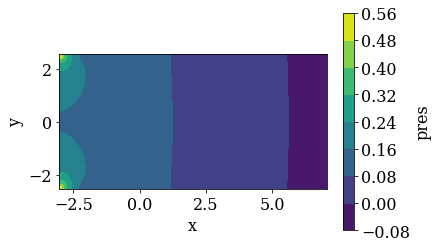

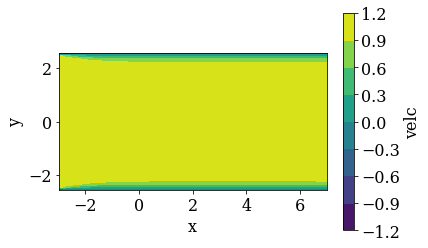

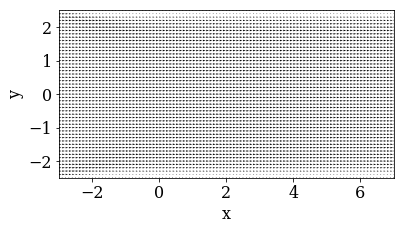

------------ Time = 2.099999999999999 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 6.472204214660684e-08
Max, Min, U   : 1.130993235354159, -1.0
Max, Min, V   : 0.11942582757798378, -0.11942582757798366
Max, Min, P   : 0.4956574364116192, -0.02671880006812784
Max, Min, DIV : 3.9317399846972023e-07, -6.131938754504185e-09


------------ Time = 2.199999999999997 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 6.273322756977885e-08
Max, Min, U   : 1.131378881275298, -1.0
Max, Min, V   : 0.11947676592811764, -0.11947676592811769
Max, Min, P   : 0.4941070489687167, -0.02593787721719539
Max, Min, DIV : 3.7262039254137846e-07, 1.3846187820647574e-08


------------ Time = 2.299999999999995 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 6.071272486785316e-08
Max, Min, U   : 1.131776818715225, -1.0
Max, Min, V   : 0.11953565371687307, -0.11953565371687302
Max, Min, P   : 0.4926438579395449, -0.025

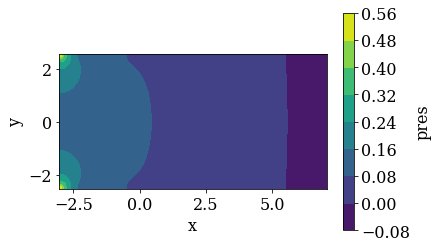

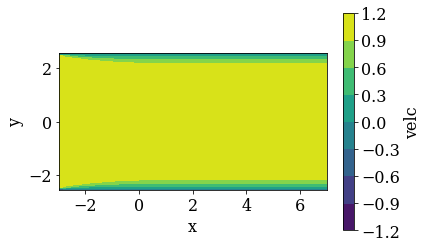

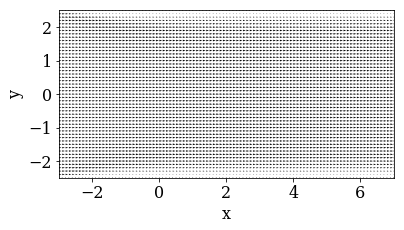

------------ Time = 3.099999999999978 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 4.3634427731022474e-08
Max, Min, U   : 1.1334673269254036, -1.0
Max, Min, V   : 0.11984062868429575, -0.1198406286842958
Max, Min, P   : 0.4836607742252302, -0.023191512053335278
Max, Min, DIV : 2.1861007024059909e-07, 7.546885197979789e-08


------------ Time = 3.1999999999999758 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 4.153691360525836e-08
Max, Min, U   : 1.1335448517557065, -1.0
Max, Min, V   : 0.11986215245164471, -0.11986215245164464
Max, Min, P   : 0.48283419279550727, -0.023128092711930216
Max, Min, DIV : 2.0565563199279047e-07, 7.578970916848927e-08


------------ Time = 3.2999999999999736 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 3.9478489511039784e-08
Max, Min, U   : 1.1335366141677217, -1.0
Max, Min, V   : 0.11988083687585546, -0.11988083687585561
Max, Min, P   : 0.4820645515757882,

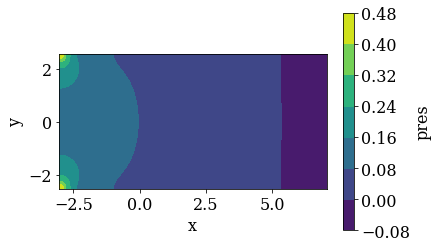

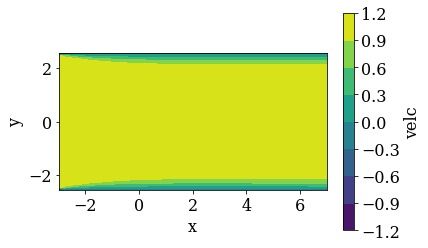

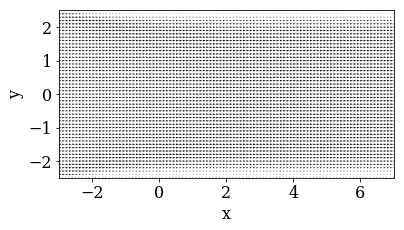

------------ Time = 4.099999999999957 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 2.492991530184757e-08
Max, Min, U   : 1.1348711589237115, -1.0
Max, Min, V   : 0.11998569353259572, -0.1199856935325961
Max, Min, P   : 0.4776793435605408, -0.023133193786150315
Max, Min, DIV : 1.1748021733722146e-07, 6.309407909544165e-08


------------ Time = 4.199999999999955 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 2.3381433438812653e-08
Max, Min, U   : 1.1350274729736234, -1.0
Max, Min, V   : 0.11999444679598616, -0.11999444679598623
Max, Min, P   : 0.47732026136678596, -0.02315855013804939
Max, Min, DIV : 1.1010928611460613e-07, 6.099883390130005e-08


------------ Time = 4.299999999999953 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 2.18945356131877e-08
Max, Min, U   : 1.1351833697786535, -1.0
Max, Min, V   : 0.12000249772400931, -0.12000249772400931
Max, Min, P   : 0.47699665198955304, -0.

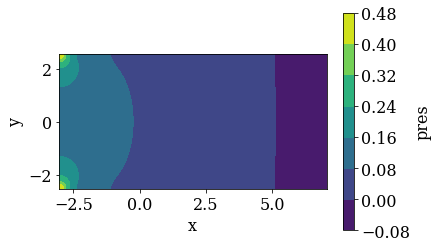

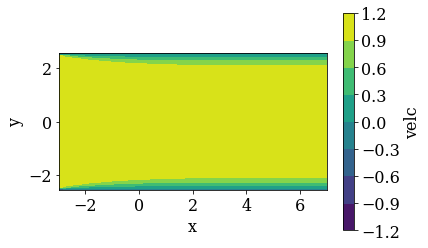

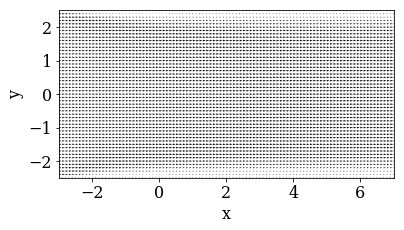

------------ Time = 5.099999999999936 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 1.2132647934229474e-08
Max, Min, U   : 1.1374945139223134, -1.0
Max, Min, V   : 0.12004775666933004, -0.12004775666933004
Max, Min, P   : 0.4754868079240991, -0.02334651012321152
Max, Min, DIV : 5.9299918809535145e-08, 3.174690765828103e-08


------------ Time = 5.199999999999934 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 1.1166993555258472e-08
Max, Min, U   : 1.137805042047352, -1.0
Max, Min, V   : 0.12005170400350955, -0.12005170400350941
Max, Min, P   : 0.47541095391160404, -0.023359436980356345
Max, Min, DIV : 5.511491250255354e-08, 2.6646274964292616e-08


------------ Time = 5.299999999999931 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 1.0255913525205998e-08
Max, Min, U   : 1.1381008684608662, -1.0
Max, Min, V   : 0.12005537910627621, -0.12005537910627617
Max, Min, P   : 0.4753558455637733, -

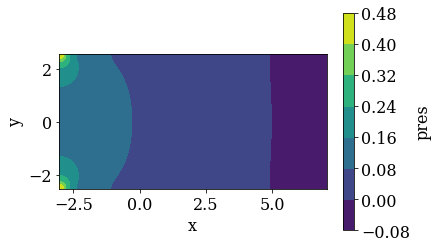

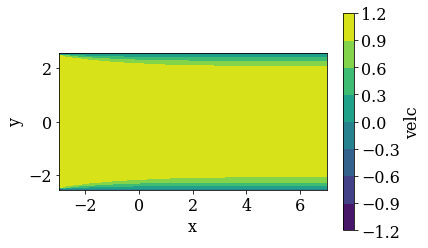

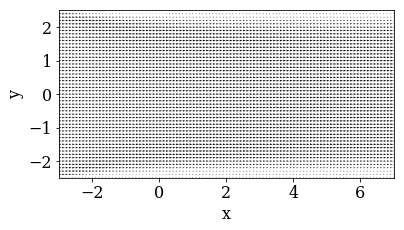

------------ Time = 6.099999999999914 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 5.011108015254067e-09
Max, Min, U   : 1.1412097521853093, -1.0
Max, Min, V   : 0.12007704249865207, -0.12007704249865203
Max, Min, P   : 0.47553346171507754, -0.023427271416117817
Max, Min, DIV : 2.8110607757823262e-08, -7.95609889081561e-09


------------ Time = 6.199999999999912 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 4.640052369326223e-09
Max, Min, U   : 1.1416582599050247, -1.0
Max, Min, V   : 0.12007900345093028, -0.12007900345093016
Max, Min, P   : 0.47561869031962006, -0.02343422917630842
Max, Min, DIV : 2.620037802995379e-08, -1.0735062727640354e-08


------------ Time = 6.29999999999991 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 4.34124556099143e-09
Max, Min, U   : 1.1420820811448522, -1.0
Max, Min, V   : 0.12008083660940787, -0.1200808366094079
Max, Min, P   : 0.47571509518229604, -0.

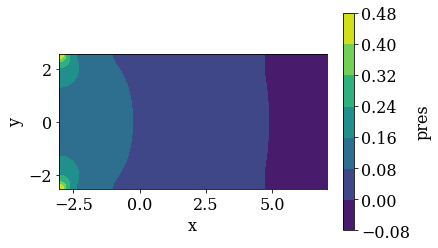

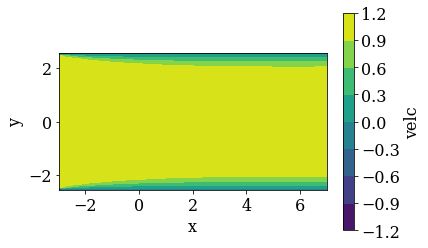

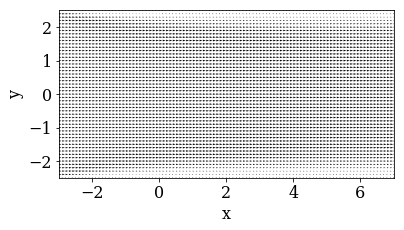

------------ Time = 7.099999999999893 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 4.153697584472729e-09
Max, Min, U   : 1.1456159037219438, -1.0
Max, Min, V   : 0.12009188451349252, -0.12009188451349262
Max, Min, P   : 0.47680312327643215, -0.02363957724191821
Max, Min, DIV : 1.512029048126272e-08, -2.839321322500865e-08


------------ Time = 7.199999999999891 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 4.283678738025454e-09
Max, Min, U   : 1.1461726436909345, -1.0
Max, Min, V   : 0.12009290882544142, -0.12009290882544141
Max, Min, P   : 0.4769689967355899, -0.023698197711272826
Max, Min, DIV : 1.4120668828882313e-08, -2.9641404108993186e-08


------------ Time = 7.299999999999889 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 4.419892205054057e-09
Max, Min, U   : 1.1467071749948552, -1.0
Max, Min, V   : 0.12009387094485016, -0.12009387094485008
Max, Min, P   : 0.47713952165429663, 

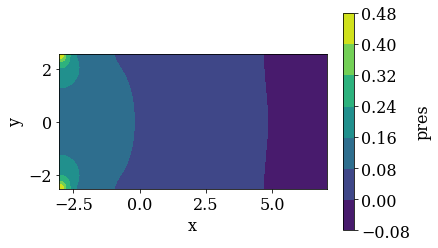

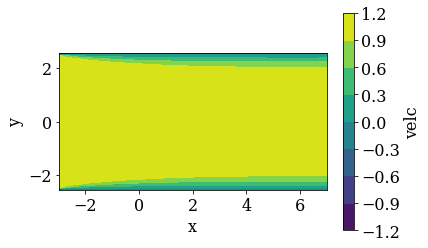

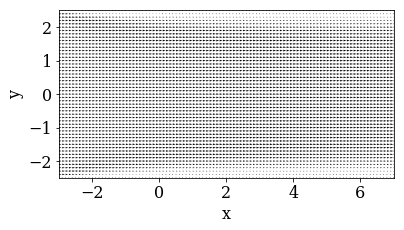

------------ Time = 8.099999999999872 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 5.252246249849827e-09
Max, Min, U   : 1.1505522794007548, -1.0
Max, Min, V   : 0.12009976162349012, -0.12009976162349009
Max, Min, P   : 0.478605222773957, -0.025570534752686305
Max, Min, DIV : 5.856495684675861e-09, -3.533190207072323e-08


------------ Time = 8.19999999999987 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 5.2865995235373195e-09
Max, Min, U   : 1.151180826660042, -1.0
Max, Min, V   : 0.1201003165340713, -0.12010031653407119
Max, Min, P   : 0.47879275075633265, -0.02610866085545607
Max, Min, DIV : 4.947169065573111e-09, -3.533674064470915e-08


------------ Time = 8.299999999999867 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 5.299921764269585e-09
Max, Min, U   : 1.151793915339086, -1.0
Max, Min, V   : 0.12010083913592529, -0.12010083913592531
Max, Min, P   : 0.4789792539958892, -0.0267

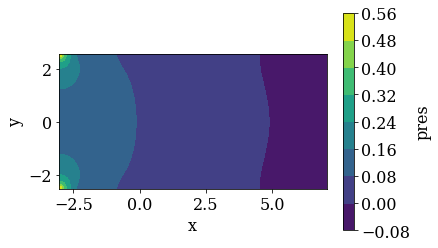

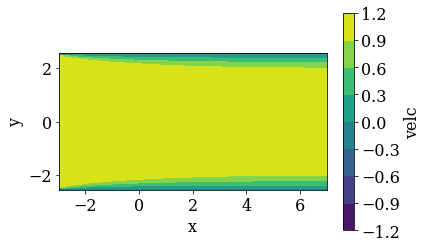

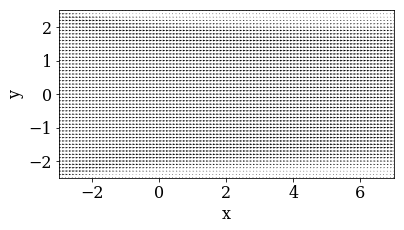

------------ Time = 9.09999999999985 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 4.829966717365755e-09
Max, Min, U   : 1.1573991930412026, -1.0
Max, Min, V   : 0.12010406649812096, -0.12010406649812076
Max, Min, P   : 0.4803685393356488, -0.03336725163554616
Max, Min, DIV : -1.692658641234187e-09, -3.074128807067922e-08


------------ Time = 9.199999999999848 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 4.787353974218295e-09
Max, Min, U   : 1.1582197812943409, -1.0
Max, Min, V   : 0.12010437334584285, -0.12010437334584254
Max, Min, P   : 0.48052672697937754, -0.0333515778040922
Max, Min, DIV : -1.455401125788e-09, -3.036034856851444e-08


------------ Time = 9.299999999999846 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 4.781492901882812e-09
Max, Min, U   : 1.1590382852595364, -1.0
Max, Min, V   : 0.12010466325821927, -0.12010466325821881
Max, Min, P   : 0.4806832730285476, -0.0328

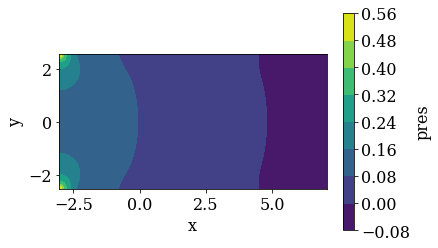

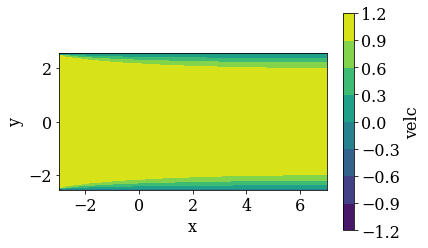

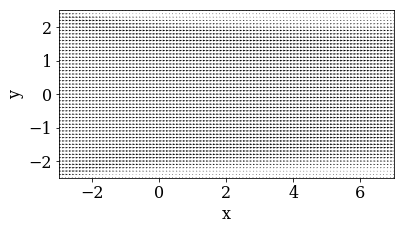

In [4]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

while scalars.variable['time'] <= scalars.variable['tmax']:
    
    # Compute mass in the domain
    Qin = (simulation.get_qin(gridx, 'velc', bc_type_u['velc']) +
           simulation.get_qin(gridy, 'velc', bc_type_v['velc']))
    
    # Update the outflow boundary velocity using a convective equation.
    simulation.update_outflow_bc(gridx, 'velc', dt)
    
    # Predictor Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')
    
    # Divergence Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'divergence')
    
    # Compute mass out of the domain
    Qout = (simulation.get_qout(gridx, 'velc', bc_type_u['velc']) +
            simulation.get_qout(gridy, 'velc', bc_type_v['velc']))
    
    # Rescale velocity at outflow and update BC for corrector step
    simulation.rescale_velocity(gridx, 'velc', bc_type_u['velc'],
                                Qin, Qout) 
    simulation.update_outflow_bc(gridx, 'velc', dt, convvel=0.0)
    
    # Solve the pressure Poisson equation 
    ites, res = flowx.poisson.solve_jacobi(gridc, 'pres', 'divv',
                                         maxiter=2000, tol=1e-9)
    scalars.stats['ites'], scalars.stats['res'] = ites, res
    
    # Corrector Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')
    
    # Display stats
    if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)  
        
    if scalars.variable['nstep'] % 100 == 0:
        flowx.io.plot_contour(gridc, 'pres')
        flowx.io.plot_contour(gridx, 'velc')
        flowx.io.plot_vector(gridx,gridy,'velc')
              
    scalars.advance()

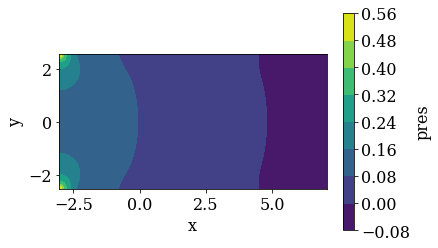

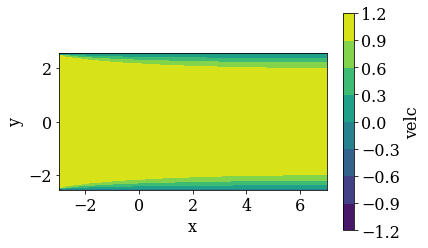

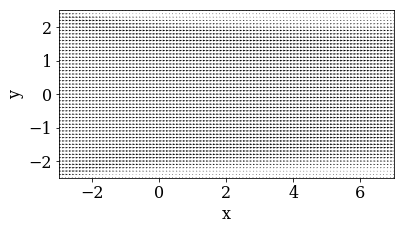

In [5]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_vector(gridx,gridy,'velc')